# Artificial Neural Network and Deep Learning : Multivariate Timeseries Classification

- Authors: Simon LESOUEF, Achille GELLENS, Lucas FOUREST
- Team Name: Les Appreneurs Profonds
- Working period: 09/12/22 - 23/12/22

## Preparation of the environment of the homework



In [297]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/A2NDL/P2/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/A2NDL/P2


In [298]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers

In [299]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Exploratory data analysis

In [300]:
x_train_val = np.load('x_train.npy')
y_train_val = np.load('y_train.npy')

print(x_train_val.shape)
print(y_train_val.shape)

(2429, 36, 6)
(2429,)


The given training-validation dataset contains 2429 samples represented by 6 variables over a timeframe of length 36. What this data actually represents is not specified. All we know is each sample is associated to a single class that we will aim to correctly predict. We are in a Many-To-One case of sequence classification.

The labels supposedly associated with each class are as follows:

- 0: Wish
- 1: Another
- 2: Comfortably
- 3: Money
- 4: Breathe
- 5: Time
- 6: Brain
- 7: Echoes
- 8: Wearing
- 9: Sorrow
- 10: Hey
- 11: Shine

In [301]:
labels={0: "Wish",
        1: "Another",
        2: "Comfortably",
        3: "Money",
        4: "Breathe",
        5: "Time",
        6: "Brain",
        7: "Echoes",
        8: "Wearing",
        9: "Sorrow",
        10: "Hey",
        11: "Shine"}

## CLass distribution

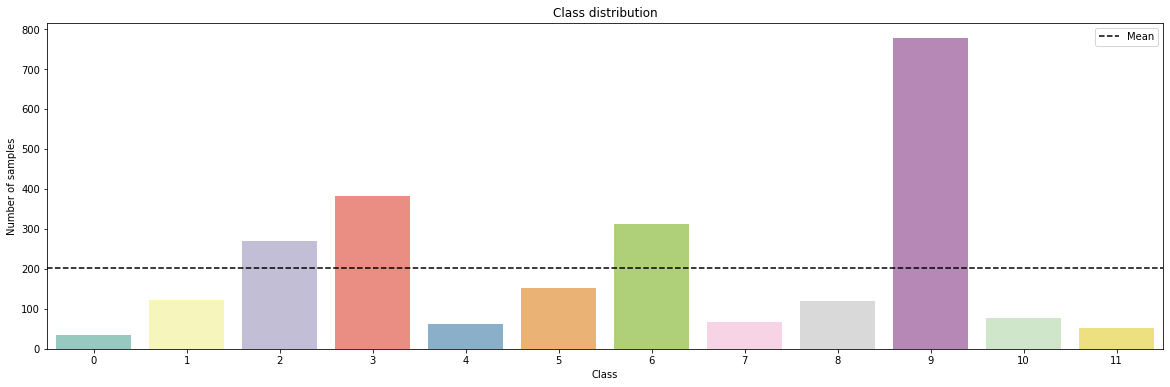

In [302]:
class_counts = np.unique(y_train_val, return_counts=True)
_, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x=class_counts[0], y=class_counts[1], ax=ax, palette="Set3")
ax.axhline(np.mean(class_counts[1]), linestyle="--", color="black", label="Mean")
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.legend()
plt.show()

In [303]:
class_repartitions={"Wish":0,"Another":0,"Comfortably":0,"Money":0,"Breathe":0,"Time":0,"Brain":0,"Echoes":0,"Wearing":0,"Sorrow":0,"Hey":0,"Shine":0}

for y in y_train_val:
    label=labels[y]
    class_repartitions[label]=class_repartitions[label]+1
  
print("Features distribution:")
for cle,val in class_repartitions.items():
  print(f' • {cle} : {val}')

Features distribution:
 • Wish : 34
 • Another : 123
 • Comfortably : 270
 • Money : 381
 • Breathe : 62
 • Time : 153
 • Brain : 313
 • Echoes : 68
 • Wearing : 120
 • Sorrow : 777
 • Hey : 77
 • Shine : 51


There is a great class imbalance in the dataset, up to a factor of nearly 23 times between the smallest and the biggest class (respectively wish and wearing). Even the second biggest class is only half the size of the biggest.

## Visualize the data

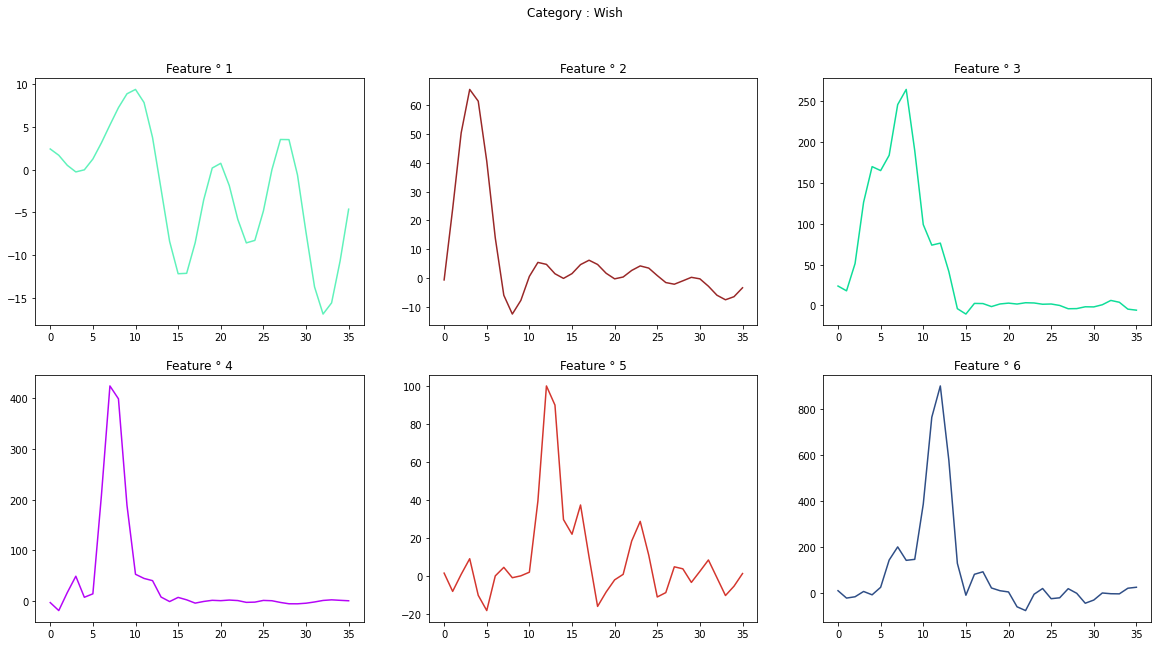

In [304]:
def plot_example(random_index, x,y ):
    example=x[random_index]
    example_label=y[random_index]

    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(example.shape[1]):
        row= i//3
        col= i%3
        example_on_ith_feature=example[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        color=[np.random.random(),np.random.random(),np.random.random()]
        axs[row,col].plot(example_on_ith_feature, c=color)

plot_example(1,x_train_val,y_train_val)

# Preprocess the data

- Scaling the data

We implemented the RobustScaler method of sklearn after comparing the results we obtained with normalisation or standardisation. This method has the advantage of being less influenced by potential outliers in the data.

In [305]:
from sklearn.preprocessing import RobustScaler

x_train_scale = np.copy(x_train_val)

for i in range(x_train_val.shape[2]):
  transformer = RobustScaler().fit(x_train_val[:,:,i])
  x_train_scale[:,:,i] = transformer.transform(x_train_val[:,:,i])

- Data Augmentation

To realize the data augmentation in this project, we relied on the content of the GitHub repository : [time_series_augmentation](https://github.com/uchidalab/time_series_augmentation).

All the methods below are not used in the best model we have developed, but they have participated in the search for the best model as we have tried in different combinations to augment the data.

In [306]:
def jitter(x):
  return x + np.random.normal(loc=0., scale=0.9, size=x.shape)

def permutation(x, max_segments, seg_mode="equal"):
  orig_steps = np.arange(x.shape[1])
  
  num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
  ret = np.zeros_like(x)
  for i, pat in enumerate(x):
      if num_segs[i] > 1:
          if seg_mode == "random":
              split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
              split_points.sort()
              splits = np.split(orig_steps, split_points)
          else:
              splits = np.array_split(orig_steps, num_segs[i])
          warp = np.concatenate(np.random.permutation(splits)).ravel()
          ret[i] = pat[warp]
      else:
          ret[i] = pat
  return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

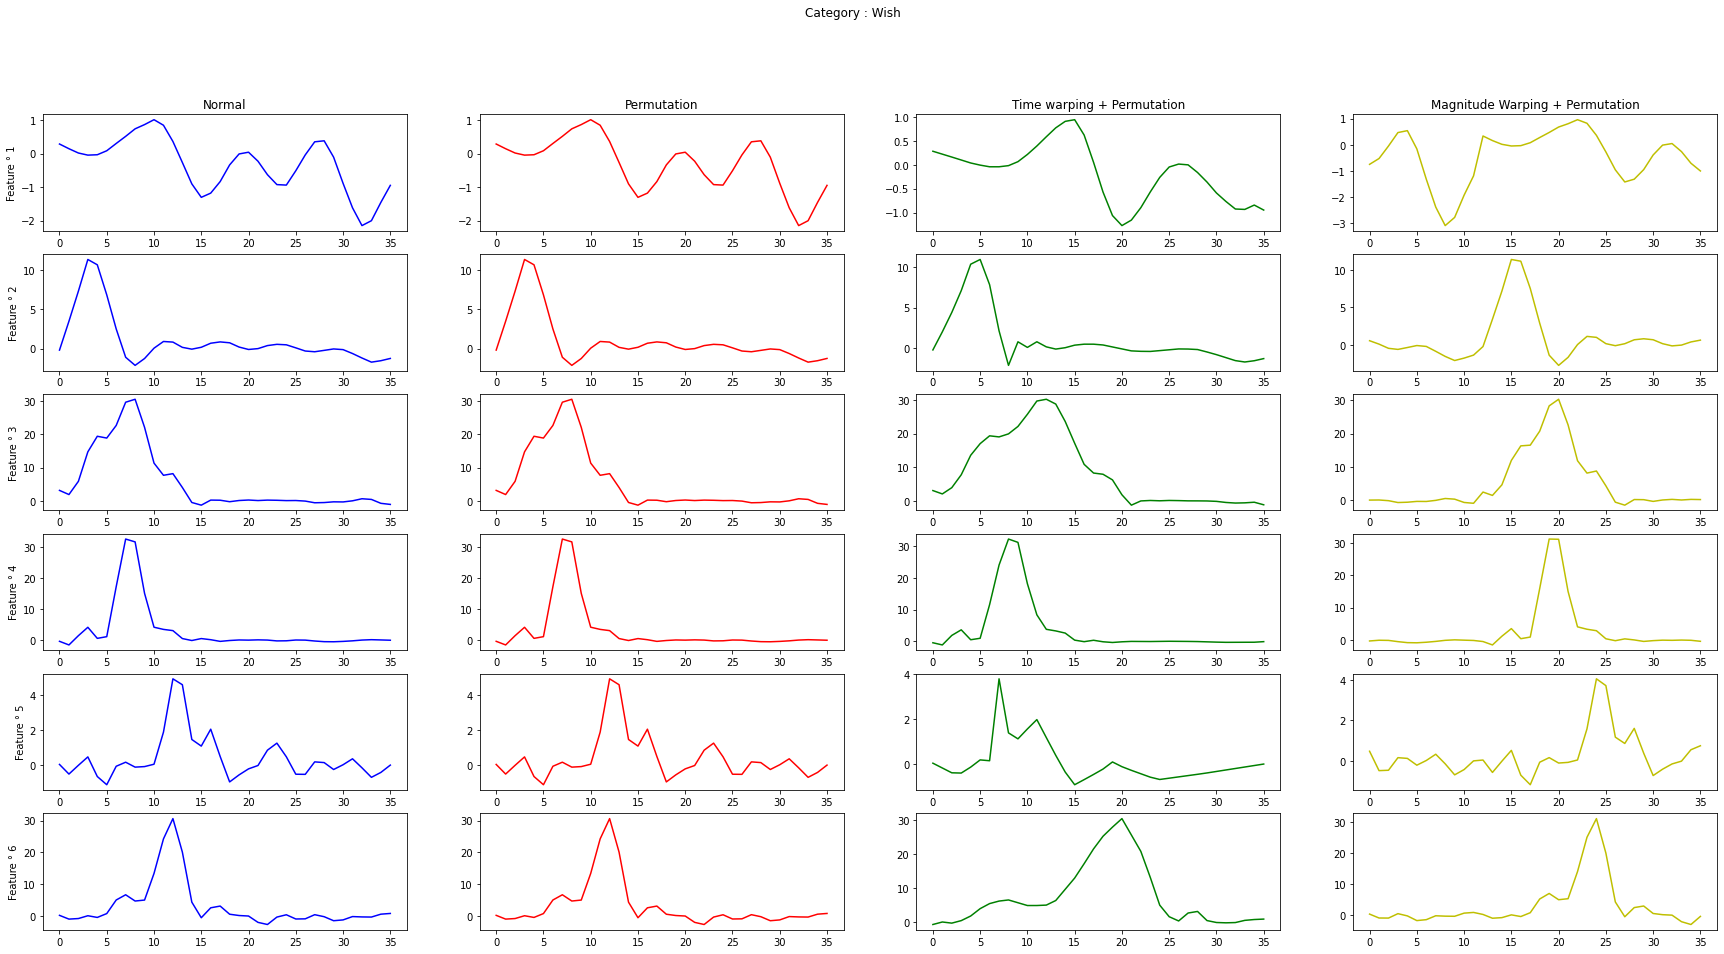

In [307]:
def plot_example_aug(random_index, x, y):
    #augmentation of the data
    x_aug1 = permutation(x, 5)
    x_aug2 = time_warp(permutation(x, 5))
    x_aug3 = magnitude_warp(permutation(x, 5))

    #visualization of an example
    example=x[random_index]
    example_aug1=x_aug1[random_index]
    example_aug2=x_aug2[random_index]
    example_aug3=x_aug3[random_index]
    example_label=y[random_index]

    fig, axs= plt.subplots(6, 4, figsize=(30,15))
    fig.suptitle('Category : '+labels[example_label])
    axs[0,0].set_title('Normal')
    axs[0,1].set_title('Permutation')
    axs[0,2].set_title('Time warping + Permutation')
    axs[0,3].set_title('Magnitude Warping + Permutation')
    for i in range(example.shape[1]):
        example_on_ith_feature=example[:,i]
        example_on_ith_feature_aug1=example_aug1[:,i]
        example_on_ith_feature_aug2=example_aug2[:,i]
        example_on_ith_feature_aug3=example_aug3[:,i]

        axs[i,0].set_ylabel('Feature ° '+str(i+1))
        axs[i,0].plot(example_on_ith_feature, color='b')
        axs[i,1].plot(example_on_ith_feature_aug1, color='r')
        axs[i,2].plot(example_on_ith_feature_aug2, color='g')
        axs[i,3].plot(example_on_ith_feature_aug3, color='y')

plot_example_aug(1, x_train_scale, y_train_val)

- Spliting the data between a training_set and a validation_set

In [308]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_scale, y_train_val, test_size=0.2, random_state=seed, stratify=y_train_val)

- Augmentation of the training_set data

In [309]:
def augmented_data(x, y):
  new_x = np.copy(x)
  new_y = np.copy(y)

  #permutation
  x_permuted = permutation(x, 5)
  new_x = np.concatenate((new_x, x_permuted), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  #time_warp x permutation
  x_perm_tw = time_warp(permutation(x, 5))
  new_x = np.concatenate((new_x, x_perm_tw), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  #magnitude_warp x permutation
  x_perm_mw = magnitude_warp(permutation(x, 5))
  new_x = np.concatenate((new_x, x_perm_mw), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  return new_x, new_y

x_train_aug, y_train_aug = augmented_data(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train_aug.shape, y_train_aug.shape)

(1943, 36, 6) (1943,)
(7772, 36, 6) (7772,)


Data augmentation has enabled us to increase the amount of information in the training_set by a factor of 4.

# Model and training

In [310]:
# Encoding target variable
y_train_categorical = tfk.utils.to_categorical(y_train_aug)
y_val_categorical = tfk.utils.to_categorical(y_val)

- Metadata of the model

In [311]:
input_shape = x_train_aug.shape[1:]
output_shape = y_train_categorical.shape[1:]
batch_size = 128
epochs = 1000

- Model architecture

In [312]:
def build_1DCNN_classifier(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout1)
    dropout2 = tfkl.Dropout(0.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(output_shape[0], activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

- An overview of the model created

In [313]:
model = build_1DCNN_classifier(input_shape, output_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 36, 256)           4864      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 18, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 18, 256)           196864    
                                                                 
 global_average_pooling1d_12  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_24 (Dropout)        (None, 256)               0     

-  Training of the model

For the training of the model, we chose a high patience (60) and a learning rate that decreases after 20 epochs where the score didn't improve in order to obtain after the training a model that can be qualified as "optimal" for the architecture in place.

In [314]:
history = model.fit(
    x = x_train_aug,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val_categorical),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.75, min_lr=1e-5)
    ]   
).history

Epoch 1/1000
61/61 [==============================] - 1s 10ms/step - loss: 3.3411 - accuracy: 0.2616 - val_loss: 2.3167 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 2/1000
61/61 [==============================] - 0s 6ms/step - loss: 2.2551 - accuracy: 0.3748 - val_loss: 1.8809 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 3/1000
61/61 [==============================] - 0s 6ms/step - loss: 1.8893 - accuracy: 0.3991 - val_loss: 1.7217 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 4/1000
61/61 [==============================] - 0s 6ms/step - loss: 1.7985 - accuracy: 0.4258 - val_loss: 1.6447 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 5/1000
61/61 [==============================] - 0s 6ms/step - loss: 1.7224 - accuracy: 0.4498 - val_loss: 1.5363 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 6/1000
61/61 [==============================] - 0s 6ms/step - loss: 1.6690 - accuracy: 0.4628 - val_loss: 1.5291 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 7/1000
61/61 [==============================] - 0s 6ms/step - l

## Evaluation of our model

In [315]:
predictions = model.predict(x_val)

16/16 [==============================] - 0s 3ms/step


In [316]:
# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.7798
Precision: 0.8013
Recall: 0.6601
F1: 0.6989


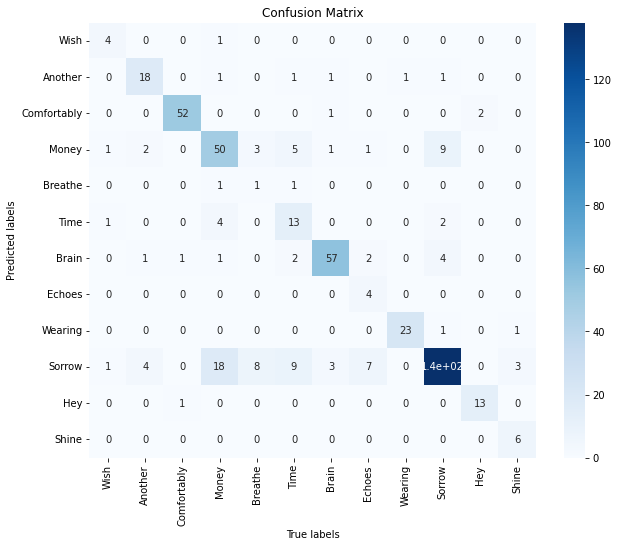

In [317]:
# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(labels.values()), yticklabels=list(labels.values()), annot=True)
plt.title('Confusion Matrix')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [318]:
#SAVE THE MODEL

#%cd /content/drive/MyDrive/Colab Notebooks/A2NDL/P2
#%mkdir -p saved_model
#model.save('saved_model/CONV1D_V5')